In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from typing import Sequence, Union, Optional
import matplotlib as mpl
import scipy.stats as stats
from scipy.stats import gaussian_kde
from typing import List, Optional, Tuple
from typing import Optional, Sequence, Union
from matplotlib.ticker import LinearLocator, StrMethodFormatter, FuncFormatter

In [2]:
plt.rcParams['xtick.labelsize'] = 10 # or whatever size you want
plt.rcParams['ytick.labelsize'] = 10 # or whatever size you want

# Set global font size for labels, titles and legends
plt.rcParams['axes.labelsize'] = 10 # or whatever size you want
plt.rcParams['axes.titlesize'] = 10 # or whatever size you want
plt.rcParams['legend.fontsize'] = 10 # or whatever size you want
#plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.linewidth'] = 0.3
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.bottom'] = True


In [3]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype']  = 42

mpl.rcParams['svg.fonttype'] = 'none'

### Figure 3,4 Experimental data

In [4]:
# import data
data = pd.read_csv("/Volumes/FallahiLab/Maize-Data/Data/Yonatan_Degefu/AP1_mechanistic_modelling/ap1_Nuc_cyt_24hr_DMSO_natural_log_data_08122025.csv")

In [5]:
# data cleaning
#remove all rows with cell line "HS695T"
data = data[data["cellline"] != "HS695T"]
# remove rows where cell line is COLO858 and are replicate_id == 1  
data = data[~((data["cellline"] == "COLO858") & (data["rep_id"] == 1))]


In [6]:
# remove "_Nuc" and "_Cyt" from the column names
data.columns = data.columns.str.replace("_Nuc", "").str.replace("_Cyt", "")

# rename columns Phospho_Erk_Rabbit to pERK, Phospho_p38 to pP38, and Phospho_JNK to pJNK
data.rename(columns={'Phospho_Erk_Rabbit': 'p-ERK', 'Phospho_p38': 'p-P38', 'Phospho_JNK': 'p-JNK','Phospho_Fra1': 'p-FRA1'}, inplace=True)
# rename cFos to cFOS, cJun to cJUN, JunD to JUND
data.rename(columns={'cFos': 'cFOS', 'cJun': 'cJUN','Fra1': 'FRA1', 'Fra2': 'FRA2', 'JunD': 'JUND'}, inplace=True)
data.head()

,cFOS,cJUN,FRA1,FRA2,JUND,p-ERK,p-JNK,p-P38,p-FRA1,condition,time,cellline,rep_id
2157,7.147183,5.722960,6.525802,6.172763,6.597472,7.165040,6.447465,5.803179,6.396484,DMSO,24 h,COLO858,2
2158,6.765179,4.621774,7.161924,6.006806,6.549695,7.070139,6.012835,5.549119,7.249780,DMSO,24 h,COLO858,2
2159,6.739002,5.116043,6.817099,5.813044,6.904365,7.165694,5.869554,5.263985,6.965047,DMSO,24 h,COLO858,2
2160,6.286608,4.834630,6.681305,7.205439,7.302219,6.938753,6.159581,5.290672,6.963001,DMSO,24 h,COLO858,2
2161,6.337903,6.113940,7.113154,6.405335,6.856567,7.183652,6.293693,5.388654,6.876600,DMSO,24 h,COLO858,2


In [7]:
# add a column pJNK/pERK, pP38/pERK
data["p-JNK/p-ERK"] = data["p-JNK"] - data["p-ERK"]
data["p-P38/p-ERK"] = data["p-P38"] - data["p-ERK"]
# add a column pJNK*pP38
data["p-JNKxp-P38"] = data["p-JNK"] + data["p-P38"]
data["p-ERKxJUND"] = data["p-ERK"] + data["JUND"]

In [8]:
# print the number of cells in each cell line for each rep_id
print(data.groupby(["cellline", "rep_id"]).size())



cellline          rep_id
A101D             1         2443
                  2         2320
A2058             1         2373
                  2         2693
A375              1         6051
                  2         6595
A375 NRAS(Q61K)  1         3296
                  2         3511
C32               1         3135
                  2         3145
COLO858           2         3256
HS294T            1         1581
                  2         1840
IGR39             1         2549
                  2         3096
LOXIMVI           1         4851
                  2         5929
MMACSF            1         2822
                  2         2914
RVH421            1          407
                  2          358
SKMEL19           1         3663
                  2         2915
SKMEL28           1         5179
                  2         4690
SKMEL5            1          716
                  2          709
UACC62            1         6331
                  2         7173
WM115             

In [9]:
want_cells = ['COLO858','WM902B','LOXIMVI','WM115']

# subset data to only include the wanted cells
cell_data = data[data['cellline'].isin(want_cells)]

# print unique cell lines
print(cell_data['cellline'].unique())

['COLO858' 'WM902B' 'LOXIMVI' 'WM115']


In [10]:
cell_data.columns

Index(['cFOS', 'cJUN', 'FRA1', 'FRA2', 'JUND', 'p-ERK', 'p-JNK', 'p-P38',
       'p-FRA1', 'condition', 'time', 'cellline', 'rep_id', 'p-JNK/p-ERK',
       'p-P38/p-ERK', 'p-JNKxp-P38', 'p-ERKxJUND'],
      dtype='object')

In [10]:
sampled_data_list = []

for cellline in cell_data['cellline'].unique():
    cellline_data = cell_data[cell_data['cellline'] == cellline]
    
    if cellline == 'COLO858':
        # COLO858 only has rep_id 2, sample all 500 cells from it
        sampled = cellline_data[cellline_data['rep_id'] == 2].sample(n=1000, random_state=42)
    else:
        # Other cell lines have 2 replicates, sample 250 from each rep_id
        rep1_data = cellline_data[cellline_data['rep_id'] == 1].sample(n=500, random_state=42)
        rep2_data = cellline_data[cellline_data['rep_id'] == 2].sample(n=500, random_state=42)
        sampled = pd.concat([rep1_data, rep2_data])
    
    sampled_data_list.append(sampled)

# Combine all sampled data
cell_data = pd.concat(sampled_data_list, ignore_index=True)

# count the number of cells in each cell line
cell_data["cellline"].value_counts()

cellline
COLO858    1000
WM902B     1000
LOXIMVI    1000
WM115      1000
Name: count, dtype: int64

In [11]:
from typing import Optional, Sequence, Union
from matplotlib.ticker import FuncFormatter

# ---------- Integer tick helpers ----------
def _no_neg_zero_int(x, pos):
    return "0" if abs(x) < 1e-12 else f"{int(np.round(x))}"

def set_integer_ticks(ax, target_ticks: int = 5):
    """
    Make exactly 5 evenly spaced INTEGER ticks that cover current ylim.
    All subplots will have exactly 5 ticks for consistency.
    """
    lo, hi = ax.get_ylim()
    if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
        lo, hi = -1.0, 1.0
        ax.set_ylim(lo, hi)

    # Calculate data span
    data_span = hi - lo
    
    # Determine step size to get exactly 5 ticks
    # 5 ticks = 4 intervals, so step = span/4, rounded up to nearest integer
    step_size = max(1, int(np.ceil(data_span / 4)))
    
    # Start from floor of minimum
    min_tick = step_size * np.floor(lo / step_size)
    
    # Calculate exactly 5 ticks (4 intervals)
    max_tick = min_tick + 4 * step_size
    
    # If this doesn't cover the data maximum, extend the range
    if max_tick < hi:
        # Shift the entire range up to cover the data
        shift = step_size * np.ceil((hi - max_tick) / step_size)
        min_tick += shift
        max_tick += shift
    
    ax.set_ylim(min_tick, max_tick)
    ax.set_yticks(np.arange(min_tick, max_tick + 0.5 * step_size, step_size))
    ax.yaxis.set_major_formatter(FuncFormatter(_no_neg_zero_int))
    ax.minorticks_off()

# ---------- Plotting ----------
def plot_protein_violins(
    df: pd.DataFrame,
    celllines: Union[str, Sequence[str]],
    proteins: Union[str, Sequence[str]],
    condition: Optional[Union[str, Sequence[str]]] = None,
    time: Optional[Union[str, Sequence[str]]] = None,
    color: str = "#0083E0",
    height: float = 3.0,
    sharey: bool = False,
    rotate_xticks: int = 30,
    save_path: Optional[str] = None,
    nrows: Optional[int] = None,
    ncols: Optional[int] = None,
    add_stats: bool = True,
    show_ns: bool = True,
    # NEW: control N-label placement
    n_label_pos: str = "above",      # "above" or "below"
    n_label_offset: float = 0.02,    # distance from axis in axes coords
    target_yticks: int = 5,          # aim for 6 integer ticks (falls back to 5)
):
    """
    Create violin plots (proteins as subplots, cell lines on x). Adds Mann-Whitney
    (Wilcoxon rank-sum) stats vs the first cell line with p-value annotations.
    """

    # Cell line color mapping
    cellline_colors = {
        "LOXIMVI": "orange",
        "WM115": "#00C957", 
        "WM902B": "violet",
        "COLO858": "#4C4C47"
    }

    # Coerce to lists
    if isinstance(celllines, (str, int)):
        celllines = [celllines]
    if isinstance(proteins, (str, int)):
        proteins = [proteins]

    # Filter
    sub = df[df["cellline"].isin(celllines)].copy()
    if condition is not None:
        conds = condition if isinstance(condition, (list, tuple, set, pd.Series)) else [condition]
        sub = sub[sub["condition"].isin(conds)]
    if time is not None:
        times = time if isinstance(time, (list, tuple, set, pd.Series)) else [time]
        sub = sub[sub["time"].isin(times)]

    # Long format
    long_df = sub.melt(
        id_vars=["condition", "time", "cellline"],
        value_vars=proteins,
        var_name="protein",
        value_name="value",
    )

    # Layout
    n = len(proteins)
    if nrows is None and ncols is None:
        nrows, ncols = n, 1
    elif nrows is not None and ncols is None:
        ncols = int(np.ceil(n / nrows))
    elif ncols is not None and nrows is None:
        nrows = int(np.ceil(n / ncols))
    elif nrows * ncols < n:
        raise ValueError(f"nrows*ncols={nrows*ncols} is less than number of proteins ({n}).")

    fig_w = ncols * 0.7585 * 2
    fig_h = nrows * 1.084 * 2
    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols, figsize=(fig_w, fig_h),
        sharex=True, sharey=sharey,
    )
    flat_axes = axes.ravel() if isinstance(axes, np.ndarray) else np.array([axes])

    def p_to_text(p: float) -> str:
        if p < 0.05:
            return f"p = {p:.1e}"
        else:
            return f"p = {p:.2f}" if show_ns else ""

    def add_sig_bar(ax, x0, x1, y, h, text, color="black", lw=0.3):
        ax.plot([x0, x0, x1, x1], [y, y+h, y+h, y], c=color, lw=lw)
        ax.text((x0 + x1) / 2.0, y + h, text, ha="center", va="bottom",
                color=color, fontsize=8)

    def format_ylabel(protein_name: str) -> str:
        if '/' in protein_name or 'x' in protein_name:
            return f"{protein_name}(log a.u.)"
        else:
            return f"{protein_name}(log a.u.)"

    # Draw each protein subplot
    for ax, prot in zip(flat_axes, proteins):
        d = long_df[long_df["protein"] == prot]

        # Create color palette for this specific set of celllines
        colors_for_plot = [cellline_colors.get(cl, color) for cl in celllines]

        # Violin with cell line-specific colors using new seaborn syntax
        sns.violinplot(
            data=d, x="cellline", y="value", hue="cellline", order=celllines, ax=ax,
            palette=colors_for_plot, cut=0, inner=None, linewidth=0.13, legend=False
        )
        
        # Overlay box (transparent fill, adjustable width)
        sns.boxplot(
            data=d, x="cellline", y="value", order=celllines, ax=ax,
            width=0.2,               # ← control the box width here
            dodge=False,              # aligns with violins
            fliersize=0,              # hide outliers
            showcaps=True,
            boxprops=dict(facecolor="none", edgecolor="black", linewidth=0.6, zorder=3),
            whiskerprops=dict(color="black", linewidth=0.6, zorder=3),
            capprops=dict(color="black", linewidth=0.6, zorder=3),
            medianprops=dict(color="black", linewidth=0.6, zorder=4)
        )

        ax.set_ylabel(format_ylabel(str(prot)))
        ax.tick_params(axis="x", rotation=rotate_xticks)

        # Tight baseline limits from data (+ small pad)
        if len(d):
            data_min = np.nanmin(d["value"].values)
            data_max = np.nanmax(d["value"].values)
        else:
            data_min, data_max = -1.0, 1.0
        rng = max(data_max - data_min, 1e-6)
        pad = 0.06 * rng
        lo, hi = data_min - pad, data_max + pad
        ax.set_ylim(lo, hi)

        # N labels in axis coords (no ylim change)
        y_base = (+n_label_offset) if n_label_pos == "above" else (-n_label_offset)
        va = "bottom" if n_label_pos == "above" else "top"
        for i, cl in enumerate(celllines):
            count = int((d["cellline"] == cl).sum())
            ax.text(
                i, y_base, f"N = {count}",
                transform=ax.get_xaxis_transform(),
                ha="center", va=va, fontsize=8, color="red",
                clip_on=False
            )

        # P-value bars; only add necessary top headroom
        if add_stats and len(celllines) > 1:
            ref = celllines[0]
            ref_vals = d.loc[d["cellline"] == ref, "value"].dropna().values
            comps = []
            for i, other in enumerate(celllines[1:], start=1):
                other_vals = d.loc[d["cellline"] == other, "value"].dropna().values
                if len(ref_vals) and len(other_vals):
                    res = stats.mannwhitneyu(ref_vals, other_vals, alternative="two-sided")
                    ptxt = p_to_text(res.pvalue)
                    if ptxt:
                        comps.append((i, ptxt))
            if comps:
                ymin, ymax = ax.get_ylim()
                yr = max(ymax - ymin, 1e-6)
                start_y = ymax + 0.04 * yr
                step = 0.08 * yr
                h = 0.02 * yr
                for idx, (i, ptxt) in enumerate(comps):
                    y = start_y + (1.5 if idx % 2 == 0 else 0.0) * step
                    add_sig_bar(ax, 0, i, y, h, ptxt)
                ax.set_ylim(ymin, max(ymax, start_y + 1.5 * step + 2 * h))

        # Integer, evenly-spaced ticks (per axis)
        set_integer_ticks(ax, target_ticks=target_yticks)

    # Hide any unused axes
    for ax in flat_axes[len(proteins):]:
        ax.axis("off")

    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, bbox_inches="tight", dpi=300, format='pdf')
    return fig, axes


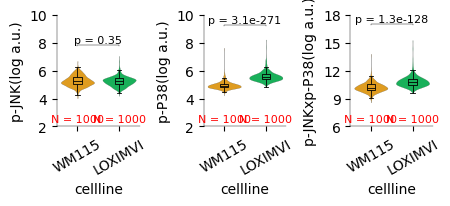

In [110]:
fig, axes = plot_protein_violins(
	cell_data,
	celllines=["WM115","LOXIMVI"],
	proteins=["p-JNK","p-P38","p-JNKxp-P38"],
	condition="DMSO",
	time="24 h",
	nrows=1, ncols=3,
	sharey=False,
    add_stats=True,
    save_path="3T_pJNK_pP38_pJNKxpP38_comparison.pdf"
)


In [12]:
thresholds = {'cFOS': {'high': 6.37},
              'cJUN': {'high': 6.25},
              'FRA1': {'high': 6.25},
              'FRA2': {'high': 6.8},
              'JUND': {'high': 5.75}
              }

In [19]:
def plot_thresholded_violins(
    df: pd.DataFrame,
    cellline: Union[str, Sequence[str]],
    x_protein: str,
    y_proteins: Union[str, Sequence[str]],
    thresholds: dict,
    condition: Optional[Union[str, Sequence[str]]] = None,
    time: Optional[Union[str, Sequence[str]]] = None,
    color: str = "#0083E0",
    height: float = 3.0,
    sharey: bool = False,
    rotate_xticks: int = 45,
    save_path: Optional[str] = None,
    nrows: Optional[int] = None,
    ncols: Optional[int] = None,
    add_stats: bool = True,
    show_ns: bool = True,
    # NEW to match the example:
    n_label_pos: str = "above",      # "above" or "below"
    n_label_offset: float = 0.02,    # in axes coords
    target_yticks: int = 5,          # aim for 6 integer ticks
):
    """
    Plot violins of y_proteins split by x_protein^low/high within ONE cell line.
    Adds Mann-Whitney stats and uses integer y-ticks with no '-0'.
    """

    # --- Cell line → color map (same as your example) ---
    cellline_colors = {
        "LOXIMVI": "orange",
        "WM115": "#00C957",
        "WM902B": "violet",
        "COLO858": "#4C4C47",
    }

    # --- Coerce args ---
    if isinstance(cellline, (list, tuple, set, pd.Series)):
        if len(cellline) != 1:
            raise ValueError("Provide exactly one cell line for thresholded plots.")
        cellline = list(cellline)[0]
    if isinstance(y_proteins, (str, int)):
        y_proteins = [y_proteins]

    # --- Filter ---
    sub = df[df["cellline"] == cellline].copy()
    if condition is not None:
        conds = condition if isinstance(condition, (list, tuple, set, pd.Series)) else [condition]
        sub = sub[sub["condition"].isin(conds)]
    if time is not None:
        times = time if isinstance(time, (list, tuple, set, pd.Series)) else [time]
        sub = sub[sub["time"].isin(times)]

    # --- Resolve threshold ---
    def resolve_threshold(th_map: dict, prot: str) -> float:
        if prot in th_map:
            val = th_map[prot]
        else:
            lut = {k.lower(): v for k, v in th_map.items()}
            if prot.lower() not in lut:
                raise KeyError(f"Threshold for '{prot}' not found.")
            val = lut[prot.lower()]
        return val["high"] if isinstance(val, dict) and "high" in val else (val if np.isscalar(val) else None)

    x_thr = resolve_threshold(thresholds, x_protein)
    if x_thr is None:
        raise ValueError(f"Invalid threshold spec for '{x_protein}'.")

    # --- Group labels with mathtext ---
    base = x_protein.replace("_", r"\_")
    low_label  = rf"${base}" + r"^{\mathrm{low}}$"
    high_label = rf"${base}" + r"^{\mathrm{high}}$"

    group_col = f"{x_protein} group"
    sub[group_col] = np.where(sub[x_protein] >= x_thr, high_label, low_label)

    # --- Long format ---
    long_df = sub.melt(
        id_vars=[group_col],
        value_vars=y_proteins,
        var_name="protein",
        value_name="value",
    )

    # --- Layout ---
    n = len(y_proteins)
    if nrows is None and ncols is None:
        nrows, ncols = n, 1
    elif nrows is not None and ncols is None:
        ncols = int(np.ceil(n / nrows))
    elif ncols is not None and nrows is None:
        nrows = int(np.ceil(n / ncols))
    elif nrows * ncols < n:
        raise ValueError(f"nrows*ncols={nrows*ncols} is less than number of y_proteins ({n}).")

    #width_per_col = 4.0
    fig_w = ncols * 0.9305 * 2
    fig_h = nrows * 1.1791 * 2
    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols, figsize=(fig_w, fig_h),
        sharex=True, sharey=sharey,
    )
    flat_axes = axes.ravel() if isinstance(axes, np.ndarray) else np.array([axes])

    def p_to_text(p: float) -> str:
        if p < 0.05:
            return f"p = {p:.1e}"
        else:
            return f"p = {p:.2f}" if show_ns else ""

    def add_sig_bar(ax, x0, x1, y, h, text, color="black", lw=0.3):
        ax.plot([x0, x0, x1, x1], [y, y+h, y+h, y], c=color, lw=lw)
        ax.text((x0 + x1) / 2.0, y + h, text, ha="center", va="bottom", color=color, fontsize=8)

    def format_ylabel(protein_name: str) -> str:
        if '/' in protein_name or 'x' in protein_name:
            return f"log({protein_name})"
        else:
            return f"log({protein_name} a.u.)"

    order = [low_label, high_label]
    cell_color = cellline_colors.get(str(cellline), color)

    for ax, prot in zip(flat_axes, y_proteins):
        d = long_df[long_df["protein"] == prot]

        # --- Draw violin (no inner box) ---
        sns.violinplot(
            data=d, x=group_col, y="value", order=order, ax=ax,
            color=cell_color, cut=0, inner=None, linewidth=0.13, legend=False
        )

        # --- Overlay transparent boxplot (like your example) ---
        sns.boxplot(
            data=d, x=group_col, y="value", order=order, ax=ax,
            width=0.2, dodge=False, fliersize=0, showcaps=True,
            boxprops=dict(facecolor="none", edgecolor="black", linewidth=0.6, zorder=3),
            whiskerprops=dict(color="black", linewidth=0.6, zorder=3),
            capprops=dict(color="black", linewidth=0.6, zorder=3),
            medianprops=dict(color="black", linewidth=0.6, zorder=4)
        )

        ax.set_xlabel("")
        ax.set_ylabel(format_ylabel(str(prot)))
        ax.tick_params(axis="x", rotation=rotate_xticks)

        # --- Tight baseline y-lims from data (+ small pad) ---
        if len(d):
            data_min = np.nanmin(d["value"].values)
            data_max = np.nanmax(d["value"].values)
        else:
            data_min, data_max = -1.0, 1.0
        rng = max(data_max - data_min, 1e-6)
        pad = 0.06 * rng
        lo, hi = data_min - pad, data_max + pad
        ax.set_ylim(lo, hi)

        # --- N labels in axis coords (no ylim change) ---
        counts_low  = int((d[group_col] == low_label).sum())
        counts_high = int((d[group_col] == high_label).sum())
        y_base = (+n_label_offset) if n_label_pos == "above" else (-n_label_offset)
        va = "bottom" if n_label_pos == "above" else "top"
        ax.text(0, y_base, f"N = {counts_low}",  transform=ax.get_xaxis_transform(),
                ha="center", va=va, fontsize=8, color="red", clip_on=False)
        ax.text(1, y_base, f"N = {counts_high}", transform=ax.get_xaxis_transform(),
                ha="center", va=va, fontsize=8, color="red", clip_on=False)

        # --- Stats: low vs high, add minimal headroom only if needed ---
        if add_stats:
            g_low  = d.loc[d[group_col] == low_label,  "value"].dropna().values
            g_high = d.loc[d[group_col] == high_label, "value"].dropna().values
            if len(g_low) and len(g_high):
                res = stats.mannwhitneyu(g_low, g_high, alternative="two-sided")
                p_text = p_to_text(res.pvalue)
                if p_text:
                    ymin, ymax = ax.get_ylim()
                    yr = max(ymax - ymin, 1e-6)
                    start_y = ymax + 0.04 * yr
                    h = 0.02 * yr
                    add_sig_bar(ax, x0=0, x1=1, y=start_y, h=h, text=p_text)
                    ax.set_ylim(ymin, max(ymax, start_y + 2 * h))

        # --- Integer, evenly-spaced ticks (per axis) ---
        set_integer_ticks(ax, target_ticks=target_yticks)

    # Hide any unused axes
    for ax in flat_axes[len(y_proteins):]:
        ax.axis("off")

    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, bbox_inches="tight", dpi=300, format='pdf')
    return fig, axes

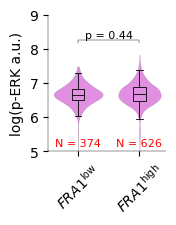

In [22]:
fig, axes = plot_thresholded_violins(
	df=cell_data,
	cellline="WM902B",
	x_protein="FRA1",
	y_proteins=["p-ERK"],
	thresholds=thresholds,
	condition="DMSO",
	time="24 h",
	nrows=1, ncols=1,
	sharey=False,
    add_stats=True,
    save_path="4H_FRA1_pERK_comparison_WM902B.pdf",
)

#### Violin comparisons for calibrated model parameters

In [13]:
# import calibrated model data
model_data = pd.read_csv('/Volumes/FallahiLab/Maize-Data/Data/Yonatan_Degefu/AP1_mechanistic_modelling/calibrated_data_parameters_initial_conditions_allcells_filtered_081225.csv')
model_data

,cell_line,param_index,init_cond_index,model_steadystate,input_state,(basal_fos).v,(basal_jun).v,(basal_fra1).v,(basal_fra2).v,(basal_jund).v,...,(degradation_fos).k1,(degradation_jun).k1,(degradation_fra1).k1,(degradation_fra2).k1,(degradation_jund).k1,fos,jun,fra1,fra2,jund
0,A101D,532,194,"high,low,low,low,high","high,low,low,low,high",25.375462,0.293757,0.207623,0.879785,4.832514,...,1.198298,1.226937,0.334726,0.217338,0.096315,179.255370,1.750838,1.379431,1.213148,78.016734
1,A101D,532,163,"high,low,low,low,high","high,low,low,low,high",25.375462,0.293757,0.207623,0.879785,4.832514,...,1.198298,1.226937,0.334726,0.217338,0.096315,234.514312,9.810124,1.093112,6.614775,94.914584
2,A101D,532,8,"high,low,low,low,high","high,low,low,low,high",25.375462,0.293757,0.207623,0.879785,4.832514,...,1.198298,1.226937,0.334726,0.217338,0.096315,111.734530,2.578653,1.458343,8.080196,66.645537
3,A101D,532,19,"high,low,low,low,high","high,low,low,low,high",25.375462,0.293757,0.207623,0.879785,4.832514,...,1.198298,1.226937,0.334726,0.217338,0.096315,241.707260,1.288831,2.498698,0.740262,58.843376
4,A101D,532,88,"high,low,low,low,high","high,low,low,low,high",25.375462,0.293757,0.207623,0.879785,4.832514,...,1.198298,1.226937,0.334726,0.217338,0.096315,28.665408,1.024603,1.226207,0.382405,10.112228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
721178,WM902B,19973,101,"high,low,high,low,high","high,low,high,low,high",28.610702,0.112921,6.466851,1.394645,3.290192,...,1.436447,1.416375,0.332745,0.159908,0.087497,15.457735,1.623207,15.652104,3.721252,18.812177
721179,WM902B,19973,37,"high,low,high,low,high","high,low,high,low,high",28.610702,0.112921,6.466851,1.394645,3.290192,...,1.436447,1.416375,0.332745,0.159908,0.087497,135.414453,0.602182,30.314732,6.306824,110.328357
721180,WM902B,19973,0,"high,low,high,low,high","high,low,high,low,high",28.610702,0.112921,6.466851,1.394645,3.290192,...,1.436447,1.416375,0.332745,0.159908,0.087497,29.226067,5.952171,67.973555,4.615749,163.346853
721181,WM902B,19973,60,"high,low,high,low,high","high,low,high,low,high",28.610702,0.112921,6.466851,1.394645,3.290192,...,1.436447,1.416375,0.332745,0.159908,0.087497,106.223962,0.578846,58.061166,4.450853,81.673171


In [14]:
import re

def rename_columns(df):
    new_column_names = {}
    
    def convert_protein_names(text):
        """Convert protein names - order is critical!"""
        # Do longer/more specific names first to avoid partial matches
        text = text.replace('jund', 'JUND')  # Do jund before jun
        text = text.replace('fra2', 'FRA2')  # Do fra2 before fra1
        text = text.replace('fra1', 'FRA1')
        text = text.replace('jun', 'cJUN')   # Do jun after jund
        text = text.replace('fos', 'cFOS')
        return text
    
    for col in df.columns:
        # For basal columns: replace with α (alpha) and add underscore
        if 'basal' in col:
            protein = re.search(r'basal_(\w+)', col).group(1)
            converted_protein = convert_protein_names(protein)
            new_column_names[col] = f"α_{converted_protein}"
        
        # For degradation columns: replace with γ (gamma) and add underscore
        elif 'degradation' in col:
            protein = re.search(r'degradation_(\w+)', col).group(1)
            converted_protein = convert_protein_names(protein)
            new_column_names[col] = f"γ_{converted_protein}"
        
        # For beta columns: replace with β (beta) and add underscore
        elif '.beta' in col:
            interaction = re.search(r'\((.*?)\)\.beta', col).group(1)
            converted_interaction = convert_protein_names(interaction)
            new_column_names[col] = f"β_{converted_interaction}"
        
        # Keep any other columns as is (like 'interest_class')
        else:
            new_column_names[col] = col
    
    return df.rename(columns=new_column_names)

# Apply the renaming to your existing subset_data
clean_model_data = rename_columns(model_data.copy())
clean_model_data.columns

Index(['cell_line', 'param_index', 'init_cond_index', 'model_steadystate',
       'input_state', 'α_cFOS', 'α_cJUN', 'α_FRA1', 'α_FRA2', 'α_JUND',
       'β_cJUN_by_cJUNcJUN', 'β_cJUN_by_cJUNcFOS', 'β_FRA1_by_cJUNFRA1',
       'β_FRA1_by_JUNDcFOS', 'β_FRA2_by_cJUNFRA2', 'γ_cFOS', 'γ_cJUN',
       'γ_FRA1', 'γ_FRA2', 'γ_JUND', 'fos', 'jun', 'fra1', 'fra2', 'jund'],
      dtype='object')

In [15]:
# subset model data to only include want cells
want_cells = ['COLO858','WM902B','LOXIMVI','WM115']
clean_model_data = clean_model_data[clean_model_data['cell_line'].isin(want_cells)]

# keep only unique param_index in each cell line
clean_model_data = clean_model_data.drop_duplicates(subset=['param_index','cell_line'])

# remove the columns param_index, init_cond_index, model_steadystate, input_state, fos, jun, fra1, fra2, jund
clean_model_data = clean_model_data.drop(columns=['param_index', 'init_cond_index', 'model_steadystate', 'input_state', 'fos', 'jun', 'fra1', 'fra2', 'jund'])

clean_model_data

,cell_line,α_cFOS,α_cJUN,α_FRA1,α_FRA2,α_JUND,β_cJUN_by_cJUNcJUN,β_cJUN_by_cJUNcFOS,β_FRA1_by_cJUNFRA1,β_FRA1_by_JUNDcFOS,β_FRA2_by_cJUNFRA2,γ_cFOS,γ_cJUN,γ_FRA1,γ_FRA2,γ_JUND
279576,COLO858,0.736696,0.208481,3.860630,0.576094,2.583550,163.182426,20.003507,17.604866,3.421786,20.609518,0.432049,0.792910,0.235496,0.138084,0.082493
279583,COLO858,9.328995,1.703815,0.305780,0.219589,4.414597,6.828591,23.152423,75.653197,69.836191,3.438550,1.628208,1.297903,0.238764,0.163149,0.130612
279590,COLO858,0.117635,1.808235,4.990418,0.205889,3.812949,4.340457,4.658964,2.604450,19.495542,9.741050,1.691048,0.847354,0.314427,0.161553,0.081341
279597,COLO858,5.386272,3.012610,2.766455,0.385897,2.733109,88.379336,15.165087,90.046640,130.804609,5.736238,1.313005,1.047073,0.332333,0.097079,0.097771
279604,COLO858,0.280377,0.750884,6.970704,0.501034,2.138560,45.219257,3.437213,10.249371,4.508070,49.260418,0.539335,0.852888,0.482726,0.170813,0.168969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720096,WM902B,38.610729,0.235001,2.767713,0.181929,4.633754,25.425967,35.661127,8.239825,18.667039,7.784138,0.730021,0.762393,0.295129,0.283258,0.067300
720130,WM902B,21.763516,0.238272,0.531291,0.573829,4.745116,3.441810,39.929947,2.709599,22.279813,8.472430,0.707150,0.548166,0.453109,0.114084,0.068736
720296,WM902B,10.328433,0.090129,0.123665,0.380765,5.612537,24.924425,137.720689,8.397163,126.821351,26.856812,0.441565,0.926149,0.356156,0.271863,0.123892
720382,WM902B,25.886819,0.087272,2.943355,1.602087,7.250808,5.381743,53.237368,29.826720,21.131270,39.121961,0.454923,0.629113,0.653642,0.169937,0.083712


In [16]:
# add columns to clean_model_data
clean_model_data["α_cJUN/α_cFOS"] = clean_model_data["α_cJUN"] / clean_model_data["α_cFOS"]
clean_model_data["α_FRA2/α_cFOS"] = clean_model_data["α_FRA2"] / clean_model_data["α_cFOS"]
clean_model_data["α_cJUNxα_FRA2"] = clean_model_data["α_cJUN"] * clean_model_data["α_FRA2"]
# add a column pJNK*pP38
clean_model_data["α_cFOSxα_JUND"] = clean_model_data["α_cFOS"] * clean_model_data["α_JUND"]


In [17]:
# count the number of cells in each cell line
clean_model_data['cell_line'].value_counts()

cell_line
COLO858    1450
WM115      1115
WM902B      519
LOXIMVI     175
Name: count, dtype: int64

In [18]:
# We decided to go with no sampling hence why sample_data is the same as clean_model_data

sample_data = clean_model_data.copy()
sample_data

,cell_line,α_cFOS,α_cJUN,α_FRA1,α_FRA2,α_JUND,β_cJUN_by_cJUNcJUN,β_cJUN_by_cJUNcFOS,β_FRA1_by_cJUNFRA1,β_FRA1_by_JUNDcFOS,β_FRA2_by_cJUNFRA2,γ_cFOS,γ_cJUN,γ_FRA1,γ_FRA2,γ_JUND,α_cJUN/α_cFOS,α_FRA2/α_cFOS,α_cJUNxα_FRA2,α_cFOSxα_JUND
279576,COLO858,0.736696,0.208481,3.860630,0.576094,2.583550,163.182426,20.003507,17.604866,3.421786,20.609518,0.432049,0.792910,0.235496,0.138084,0.082493,0.282995,0.781997,0.120105,1.903290
279583,COLO858,9.328995,1.703815,0.305780,0.219589,4.414597,6.828591,23.152423,75.653197,69.836191,3.438550,1.628208,1.297903,0.238764,0.163149,0.130612,0.182637,0.023538,0.374139,41.183757
279590,COLO858,0.117635,1.808235,4.990418,0.205889,3.812949,4.340457,4.658964,2.604450,19.495542,9.741050,1.691048,0.847354,0.314427,0.161553,0.081341,15.371508,1.750232,0.372296,0.448538
279597,COLO858,5.386272,3.012610,2.766455,0.385897,2.733109,88.379336,15.165087,90.046640,130.804609,5.736238,1.313005,1.047073,0.332333,0.097079,0.097771,0.559313,0.071645,1.162558,14.721271
279604,COLO858,0.280377,0.750884,6.970704,0.501034,2.138560,45.219257,3.437213,10.249371,4.508070,49.260418,0.539335,0.852888,0.482726,0.170813,0.168969,2.678123,1.786999,0.376218,0.599603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720096,WM902B,38.610729,0.235001,2.767713,0.181929,4.633754,25.425967,35.661127,8.239825,18.667039,7.784138,0.730021,0.762393,0.295129,0.283258,0.067300,0.006086,0.004712,0.042753,178.912636
720130,WM902B,21.763516,0.238272,0.531291,0.573829,4.745116,3.441810,39.929947,2.709599,22.279813,8.472430,0.707150,0.548166,0.453109,0.114084,0.068736,0.010948,0.026367,0.136727,103.270416
720296,WM902B,10.328433,0.090129,0.123665,0.380765,5.612537,24.924425,137.720689,8.397163,126.821351,26.856812,0.441565,0.926149,0.356156,0.271863,0.123892,0.008726,0.036866,0.034318,57.968710
720382,WM902B,25.886819,0.087272,2.943355,1.602087,7.250808,5.381743,53.237368,29.826720,21.131270,39.121961,0.454923,0.629113,0.653642,0.169937,0.083712,0.003371,0.061888,0.139817,187.700348


In [40]:
def plot_violin_model(
    df: pd.DataFrame,
    cell_lines: Union[str, Sequence[str]],
    parameters: Union[str, Sequence[str]],
    color: str = "#0083E0",
    height: float = 3.0,
    sharey: bool = False,
    rotate_xticks: int = 30,
    save_path: Optional[str] = None,
    nrows: Optional[int] = None,
    ncols: Optional[int] = None,
    add_stats: bool = True,
    show_ns: bool = True,
    log_eps: Optional[float] = None,   # if None: drop nonpositive; else add eps before log10
    # NEW to match example:
    n_label_pos: str = "above",      # "above" or "below"
    n_label_offset: float = 0.02,    # distance from axis in axes coords
    target_yticks: int = 5,          # aim for 6 integer ticks (falls back to 5)
):
    """
    Violin plots of model parameters by cell line (values log10-transformed).
    - First cell line is the reference for Mann–Whitney U tests.
    - y-axis label: 'log10(parameter_name nM)'.
    DataFrame must have a 'cell_line' column and parameter columns.
    """

    # Cell line → color map (same mapping as your other function)
    cellline_colors = {
        "LOXIMVI": "orange",
        "WM115": "#00C957",
        "WM902B": "violet",
        "COLO858": "#4C4C47",
    }

    # --- Coerce args ---
    if isinstance(cell_lines, (str, int)):
        cell_lines = [cell_lines]
    if isinstance(parameters, (str, int)):
        parameters = [parameters]

    # --- Filter to chosen cell lines ---
    sub = df[df["cell_line"].isin(cell_lines)].copy()

    # --- Long format ---
    long_df = sub.melt(
        id_vars=["cell_line"],
        value_vars=parameters,
        var_name="parameter",
        value_name="value",
    )

    # --- Log10 transform ---
    if log_eps is not None:
        long_df["value"] = np.log10(long_df["value"].astype(float) + float(log_eps))
    else:
        long_df = long_df[long_df["value"] > 0].copy()
        long_df["value"] = np.log10(long_df["value"].astype(float))

    # --- Layout ---
    n = len(parameters)
    if nrows is None and ncols is None:
        nrows, ncols = n, 1
    elif nrows is not None and ncols is None:
        ncols = int(np.ceil(n / nrows))
    elif ncols is not None and nrows is None:
        nrows = int(np.ceil(n / ncols))
    elif nrows * ncols < n:
        raise ValueError(f"nrows*ncols={nrows*ncols} is less than number of parameters ({n}).")

    
    fig_w = ncols * 0.7841 *2.5
    fig_h = nrows * 1.1664 *2.5
    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols, figsize=(fig_w, fig_h),
        sharex=True, sharey=sharey,
    )
    flat_axes = axes.ravel() if isinstance(axes, np.ndarray) else np.array([axes])

    def p_to_text(p: float) -> str:
        return f"p = {p:.1e}" if p < 0.05 else (f"p = {p:.2f}" if show_ns else "")

    def add_sig_bar(ax, x0, x1, y, h, text, color="black", lw=0.3):
        ax.plot([x0, x0, x1, x1], [y, y+h, y+h, y], c=color, lw=lw)
        ax.text((x0 + x1) / 2.0, y + h, text, ha="center", va="bottom",
                color=color, fontsize=8)

    def format_ylabel(parameter_name: str) -> str:
        return f"log10({parameter_name} nM)"

    # Precompute per-cell-line colors in the chosen order
    palette_for_plot = [cellline_colors.get(cl, color) for cl in cell_lines]

    # --- Draw ---
    for ax, param in zip(flat_axes, parameters):
        d = long_df[long_df["parameter"] == param]

        # Violin (category-colored)
        sns.violinplot(
            data=d, x="cell_line", y="value", order=cell_lines, ax=ax,
            palette=palette_for_plot, cut=0, inner=None, linewidth=0.13, legend=False
        )

        # Overlay transparent box
        sns.boxplot(
            data=d, x="cell_line", y="value", order=cell_lines, ax=ax,
            width=0.2, dodge=False, fliersize=0, showcaps=True,
            boxprops=dict(facecolor="none", edgecolor="black", linewidth=0.6, zorder=3),
            whiskerprops=dict(color="black", linewidth=0.6, zorder=3),
            capprops=dict(color="black", linewidth=0.6, zorder=3),
            medianprops=dict(color="black", linewidth=0.6, zorder=4)
        )

        ax.set_xlabel("cell line")
        ax.set_ylabel(format_ylabel(str(param)))
        ax.tick_params(axis="x", rotation=rotate_xticks)

        # Tight baseline limits from data (+ small pad)
        if len(d):
            data_min = np.nanmin(d["value"].values)
            data_max = np.nanmax(d["value"].values)
        else:
            data_min, data_max = -1.0, 1.0
        rng = max(data_max - data_min, 1e-6)
        pad = 0.06 * rng
        lo, hi = data_min - pad, data_max + pad
        ax.set_ylim(lo, hi)

        # N labels in axis coords (no ylim change)
        y_base = (+n_label_offset) if n_label_pos == "above" else (-n_label_offset)
        va = "bottom" if n_label_pos == "above" else "top"
        for i, cl in enumerate(cell_lines):
            count = int((d["cell_line"] == cl).sum())
            ax.text(
                i, y_base, f"N = {count}",
                transform=ax.get_xaxis_transform(),
                ha="center", va=va, fontsize=8, color="red",
                clip_on=False
            )

        # Stats: first cell line vs others; add minimal headroom only if needed
        if add_stats and len(cell_lines) > 1:
            ref = cell_lines[0]
            ref_vals = d.loc[d["cell_line"] == ref, "value"].dropna().values
            comps = []
            for i, other in enumerate(cell_lines[1:], start=1):
                other_vals = d.loc[d["cell_line"] == other, "value"].dropna().values
                if len(ref_vals) and len(other_vals):
                    res = stats.mannwhitneyu(ref_vals, other_vals, alternative="two-sided")
                    ptxt = p_to_text(res.pvalue)
                    if ptxt:
                        comps.append((i, ptxt))
            if comps:
                ymin, ymax = ax.get_ylim()
                yr = max(ymax - ymin, 1e-6)
                start_y = ymax + 0.04 * yr
                step = 0.08 * yr
                h = 0.02 * yr
                for idx, (i, ptxt) in enumerate(comps):
                    y = start_y + (1.5 if idx % 2 == 0 else 0.0) * step
                    add_sig_bar(ax, 0, i, y, h, ptxt)
                ax.set_ylim(ymin, max(ymax, start_y + 1.5 * step + 2 * h))

        # Integer, evenly-spaced ticks (per axis)
        set_integer_ticks(ax, target_ticks=target_yticks)

    # Hide unused axes
    for ax in flat_axes[len(parameters):]:
        ax.axis("off")

    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, bbox_inches="tight", dpi=300, format='pdf')
    return fig, axes

In [30]:
sample_data.columns

Index(['cell_line', 'α_cFOS', 'α_cJUN', 'α_FRA1', 'α_FRA2', 'α_JUND',
       'β_cJUN_by_cJUNcJUN', 'β_cJUN_by_cJUNcFOS', 'β_FRA1_by_cJUNFRA1',
       'β_FRA1_by_JUNDcFOS', 'β_FRA2_by_cJUNFRA2', 'γ_cFOS', 'γ_cJUN',
       'γ_FRA1', 'γ_FRA2', 'γ_JUND', 'α_cJUN/α_cFOS', 'α_FRA2/α_cFOS',
       'α_cJUNxα_FRA2', 'α_cFOSxα_JUND'],
      dtype='object')

/var/folders/__/h1scybwx6txcjzlhvr2q1wwm0000gn/T/ipykernel_14776/1697420720.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/__/h1scybwx6txcjzlhvr2q1wwm0000gn/T/ipykernel_14776/1697420720.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/__/h1scybwx6txcjzlhvr2q1wwm0000gn/T/ipykernel_14776/1697420720.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


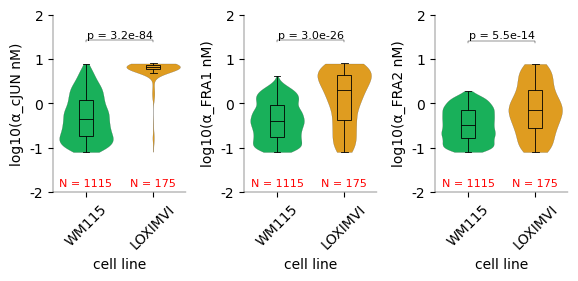

In [42]:
fig, axes = plot_violin_model(
	df=sample_data,  # your model table with 'cell_line' and parameter columns
	cell_lines=["WM115","LOXIMVI"],
	parameters=["α_cJUN","α_FRA1","α_FRA2"],
	nrows=1, ncols=3,
	sharey=False,
    add_stats=True,
	rotate_xticks=45,
    save_path = "3L_model_comparison_violin_plots_WM115_LOXIMVI.pdf"
	# log_eps=1e-12,  # optionally add epsilon instead of dropping nonpositive rows
)

### Figure 6 Anaysis of Vemurafinib and Trematinib data

In [22]:
# import data
data = pd.read_csv("/Volumes/FallahiLab/Maize-Data/Data/Yonatan_Degefu/AP1_mechanistic_modelling/ap1_Nuc_cyt_24hr_VEM_TRE_DMSO_natural_log_data_08122025.csv")
data = data[data["cellline"] != "HS695T"]
# remove rows where cell line is COLO858, condition is DMSO and are replicate_id == 1  
data = data[~((data["cellline"] == "COLO858") & (data["condition"] == "DMSO") & (data["rep_id"] == 1))]

# keep only 24 hours data 
data = data[data["time"] == '24 h']

In [23]:
# remove "_Nuc" and "_Cyt" from the column names
data.columns = data.columns.str.replace("_Nuc", "").str.replace("_Cyt", "")

# rename columns Phospho_Erk_Rabbit to pERK, Phospho_p38 to pP38, and Phospho_JNK to pJNK
data.rename(columns={'Phospho_Erk_Rabbit': 'p-ERK', 'Phospho_p38': 'p-P38', 'Phospho_JNK': 'p-JNK','Phospho_Fra1': 'p-FRA1'}, inplace=True)
# rename cFos to cFOS, cJun to cJUN, JunD to JUND
data.rename(columns={'cFos': 'cFOS', 'cJun': 'cJUN','Fra1': 'FRA1', 'Fra2': 'FRA2', 'JunD': 'JUND'}, inplace=True)
data.head()

,cFOS,cJUN,FRA1,FRA2,JUND,p-ERK,p-JNK,p-P38,p-FRA1,condition,time,cellline,rep_id
2157,7.147183,5.722960,6.525802,6.172763,6.597472,7.165040,6.447465,5.803179,6.396484,DMSO,24 h,COLO858,2
2158,6.765179,4.621774,7.161924,6.006806,6.549695,7.070139,6.012835,5.549119,7.249780,DMSO,24 h,COLO858,2
2159,6.739002,5.116043,6.817099,5.813044,6.904365,7.165694,5.869554,5.263985,6.965047,DMSO,24 h,COLO858,2
2160,6.286608,4.834630,6.681305,7.205439,7.302219,6.938753,6.159581,5.290672,6.963001,DMSO,24 h,COLO858,2
2161,6.337903,6.113940,7.113154,6.405335,6.856567,7.183652,6.293693,5.388654,6.876600,DMSO,24 h,COLO858,2


In [24]:
# print the number of cells in each cellline and rep_id 
cell_counts = data.groupby(['cellline','condition' ,'rep_id']).size().reset_index(name='count')
print(cell_counts)


    cellline                      condition  rep_id  count
0      A101D  0.316 uM Vem + 0.0316 uM Tram       1   1940
1      A101D  0.316 uM Vem + 0.0316 uM Tram       2   1784
2      A101D           0.316 uM Vemurafenib       1   2494
3      A101D           0.316 uM Vemurafenib       2   2255
4      A101D                           DMSO       1   2443
..       ...                            ...     ...    ...
108   WM902B  0.316 uM Vem + 0.0316 uM Tram       2   4532
109   WM902B           0.316 uM Vemurafenib       1   3728
110   WM902B           0.316 uM Vemurafenib       2   4193
111   WM902B                           DMSO       1   2837
112   WM902B                           DMSO       2   3904

[113 rows x 4 columns]


#### Replicate plot for each condition

In [ ]:
def plot_replicate_diagnostics(
    df: pd.DataFrame,
    protein: str,
    celllines: Optional[List[str]] = None,
    conditions: Optional[List[str]] = None,
    ylim: Optional[tuple] = None,
    share_y: bool = True,
    save_path: Optional[str] = None,
    dpi: int = 300
):
    """
    Generates a grid of violin plots to diagnose replicate consistency.
    This version automatically handles cases with one or two replicates.
    """
    # --- 1. Data Preparation ---
    sub_df = df.copy()
    sub_df['rep_id'] = sub_df['rep_id'].astype(str) # Ensure rep_id is a string

    if celllines:
        sub_df = sub_df[sub_df['cellline'].isin(celllines)]
    if conditions:
        sub_df = sub_df[sub_df['condition'].isin(conditions)]

    cell_order = celllines if celllines else sorted(sub_df['cellline'].unique())
    cond_order = conditions if conditions else sorted(sub_df['condition'].unique())

    # --- 2. Create the FacetGrid ---
    g = sns.FacetGrid(
        sub_df,
        row="cellline",
        col="condition",
        row_order=cell_order,
        col_order=cond_order,
        height=4,
        aspect=1.2,
        sharey=share_y,
        margin_titles=True
    )

    # --- 3. Map the Violin Plot onto the Grid ---
    g.map(
        sns.violinplot,
        "rep_id",
        protein,
        
        cut=0,
        inner="box",
        fill = False
    )

    # --- 4. Aesthetics and Final Touches ---
    if ylim:
        g.set(ylim=ylim)
        
    g.set_axis_labels("Replicate ID", f"log({protein} a.u.)")
    g.set_titles(col_template="{col_name}", row_template="{row_name}")
    
    #plt.suptitle(f'Replicate Consistency for {protein}', y=1.02, fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.98])

    # --- 5. Save the Figure ---
    if save_path:
        os.makedirs(os.path.dirname(save_path) or ".", exist_ok=True)
        plt.savefig(save_path, dpi=dpi, bbox_inches="tight")
        print(f"Diagnostic plot saved to: {save_path}")

    return g

# Define the conditions you want to compare
conditions_to_check = [
    "DMSO",
    "0.316 uM Vemurafenib",
    "0.316 uM Vem + 0.0316 uM Tram",
]

# Call the function with your full (unsampled) data
diagnostic_plot = plot_replicate_diagnostics(
    df=data,  # Your full dataframe
    protein="JUND", # The protein you are analyzing
    conditions=conditions_to_check,
    # You can also specify certain celllines, e.g., celllines=['A101D', 'WM902B']
    save_path="diagnostics/replicate_consistency_JUND.png"
)

# Display the plot
plt.show()

#### Sample cells and plot violoin and Single cell densiities (Figure 6)

In [25]:
from typing import List, Optional

def sample_cells(df: pd.DataFrame, 
                 target_sample_size: int = 500,
                 grouping_cols: List[str] = ['cellline', 'condition', 'time'],
                 replicate_col: str = 'rep_id',
                 random_state: Optional[int] = 42) -> pd.DataFrame:

    # Set random seed for reproducibility
    if random_state is not None:
        np.random.seed(random_state)
    
    # Count replicates per condition to adjust sampling
    replicate_counts = df.groupby(grouping_cols)[replicate_col].nunique()
    print("\nReplicate counts per condition:")
    for key, count in replicate_counts.items():
        print(f"  {key}: {count} replicate(s)")
    
    # Create full grouping including replicate for sampling
    full_grouping_cols = grouping_cols + [replicate_col]
    
    # Group by all columns including replicate
    grouped = df.groupby(full_grouping_cols)
    
    sampled_data = []
    sampling_report = []
    
    print(f"\nSampling up to {target_sample_size} cells per replicate (doubled for single replicates)...")
    
    # First pass: find the minimum sample size for each cell line across ALL conditions and replicates
    cellline_group_sizes = {}
    
    for group_key, group_data in grouped:
        group_dict = dict(zip(full_grouping_cols, group_key))
        cellline = group_dict['cellline']
        n_cells = len(group_data)
        
        # Get number of replicates for this condition
        condition_key = tuple(group_dict[col] for col in grouping_cols)
        n_replicates = replicate_counts[condition_key]
        
        # Adjust effective size based on replicate count
        # For single replicates, we'll want 2x the target, so consider half the actual size
        if n_replicates == 1:
            effective_size = n_cells / 2  # We'll sample 2x from this replicate
        else:
            effective_size = n_cells
        
        if cellline not in cellline_group_sizes:
            cellline_group_sizes[cellline] = []
        
        cellline_group_sizes[cellline].append(effective_size)
    
    # Determine sampling strategy for each cell line
    cellline_sampling_strategy = {}
    for cellline, sizes in cellline_group_sizes.items():
        min_size = min(sizes)
        max_size = max(sizes)
        
        if min_size < target_sample_size:
            # Cell line has insufficient cells - use balanced sampling with minimum size
            cellline_sampling_strategy[cellline] = int(min_size)
            print(f"Cell line {cellline}: balanced sampling with {int(min_size)} cells per replicate (effective min: {min_size:.0f}, max: {max_size:.0f})")
        else:
            # Cell line has sufficient cells - use normal sampling
            cellline_sampling_strategy[cellline] = target_sample_size
            print(f"Cell line {cellline}: normal sampling with {target_sample_size} cells per replicate (effective min: {min_size:.0f}, max: {max_size:.0f})")
    
    # Second pass: actual sampling
    for group_key, group_data in grouped:
        n_cells = len(group_data)
        
        # Extract group information
        group_dict = dict(zip(full_grouping_cols, group_key))
        cellline = group_dict['cellline']
        
        # Get number of replicates for this condition
        condition_key = tuple(group_dict[col] for col in grouping_cols)
        n_replicates = replicate_counts[condition_key]
        
        # Use the predetermined sampling strategy for this cell line
        base_sample_size = cellline_sampling_strategy[cellline]
        
        # Adjust sample size based on replicate count
        # If only 1 replicate, sample 2x to match the total from 2-replicate groups
        if n_replicates == 1:
            n_to_sample = min(base_sample_size * 2, n_cells)
            if base_sample_size * 2 > n_cells:
                print(f"  {cellline} {group_dict['condition']} Rep{group_dict[replicate_col]}: Single replicate - requested {base_sample_size * 2} but only {n_cells} available")
        else:
            n_to_sample = base_sample_size
        
        # Critical fix: Ensure we can actually sample this many cells
        if n_cells < n_to_sample:
            print(f"WARNING: {cellline} {group_dict['condition']} Rep{group_dict[replicate_col]} has only {n_cells} cells, but strategy requires {n_to_sample}")
            print(f"This will cause unbalanced sampling for {cellline}. Consider lowering target_sample_size or checking data.")
            n_to_sample = n_cells  # Take what we have
        
        # Sample cells
        if n_to_sample < n_cells:
            # Random sampling
            sampled_indices = np.random.choice(group_data.index, 
                                             size=n_to_sample, 
                                             replace=False)
            sampled_group = group_data.loc[sampled_indices]
        else:
            # Keep all cells
            sampled_group = group_data.copy()
        
        sampled_data.append(sampled_group)
        
        # Track sampling for reporting
        is_balanced = cellline_sampling_strategy[cellline] < target_sample_size
        is_single_replicate = n_replicates == 1
        sampling_report.append({
            **{col: group_dict[col] for col in grouping_cols},
            replicate_col: group_dict[replicate_col],
            'n_replicates': n_replicates,
            'original_count': n_cells,
            'sampled_count': len(sampled_group),
            'cells_discarded': n_cells - len(sampled_group),
            'balanced_sampling': is_balanced,
            'single_replicate_doubled': is_single_replicate,
            'cellline_strategy': cellline_sampling_strategy[cellline],
            'effective_target': n_to_sample,
            'sampling_success': len(sampled_group) == n_to_sample
        })
    
    # Combine all sampled data
    sampled_df = pd.concat(sampled_data, ignore_index=True)
    
    # Create sampling report
    sampling_df = pd.DataFrame(sampling_report)
    
    # Print sampling summary
    total_original = sampling_df['original_count'].sum()
    total_sampled = sampling_df['sampled_count'].sum()
    total_discarded = sampling_df['cells_discarded'].sum()
    affected_replicates = (sampling_df['cells_discarded'] > 0).sum()
    balanced_replicates = sampling_df['balanced_sampling'].sum()
    single_rep_doubled = sampling_df['single_replicate_doubled'].sum()
    failed_sampling = (~sampling_df['sampling_success']).sum()
    
    print(f"\nSampling Summary:")
    print(f"Total cells: {total_original:,} → {total_sampled:,} ({total_sampled/total_original*100:.1f}% retained)")
    print(f"Cells discarded: {total_discarded:,}")
    print(f"Replicates affected: {affected_replicates}/{len(sampling_df)}")
    print(f"Replicates with balanced sampling: {balanced_replicates}/{len(sampling_df)}")
    print(f"Single replicates (doubled): {single_rep_doubled}/{len(sampling_df)}")
    print(f"Failed to meet sampling target: {failed_sampling}/{len(sampling_df)}")
    
    # Show cell line strategies
    print(f"\nCell line sampling strategies:")
    for cellline, strategy in cellline_sampling_strategy.items():
        strategy_type = "balanced" if strategy < target_sample_size else "normal"
        print(f"  {cellline}: {strategy} cells per replicate ({strategy_type}), {strategy*2} for single replicates")
    
    # Check for sampling failures
    failed_samples = sampling_df[~sampling_df['sampling_success']]
    if len(failed_samples) > 0:
        print(f"\nSampling failures (couldn't meet target):")
        for i, row in failed_samples.iterrows():
            group_str = "_".join([str(row[col]) for col in grouping_cols])
            print(f"  {group_str} Rep{row[replicate_col]}: got {row['sampled_count']} instead of {row['effective_target']}")
    
    # Verify balanced sampling worked - now checking total cells per condition
    print(f"\nVerification - total cells per condition:")
    condition_counts = sampled_df.groupby(grouping_cols).size()
    for condition_key in condition_counts.index:
        n_cells = condition_counts[condition_key]
        n_reps = replicate_counts[condition_key]
        cellline = condition_key[0] if isinstance(condition_key, tuple) else condition_key
        expected_per_rep = cellline_sampling_strategy[cellline]
        expected_total = expected_per_rep * n_reps if n_reps > 1 else expected_per_rep * 2
        print(f"  {condition_key}: {n_cells} cells ({n_reps} replicate(s), expected: {expected_total})")
    
    print(f"\nSampling complete. Output contains {len(sampled_df)} individual cells.")
    print(f"Structure: Same as input with rep_id column preserved.")
    
    return sampled_df, sampling_df



# Sample x cells per replicate
sampled_df,sampling_report = sample_cells(
    data, 
    target_sample_size=300, # this is 600 for single cell densities 
    grouping_cols=['cellline', 'condition', 'time'],
    replicate_col='rep_id'
)
sampled_df.head()


Replicate counts per condition:
  ('A101D', '0.316 uM Vem + 0.0316 uM Tram', '24 h'): 2 replicate(s)
  ('A101D', '0.316 uM Vemurafenib', '24 h'): 2 replicate(s)
  ('A101D', 'DMSO', '24 h'): 2 replicate(s)
  ('A2058', '0.316 uM Vem + 0.0316 uM Tram', '24 h'): 2 replicate(s)
  ('A2058', '0.316 uM Vemurafenib', '24 h'): 2 replicate(s)
  ('A2058', 'DMSO', '24 h'): 2 replicate(s)
  ('A375', '0.316 uM Vem + 0.0316 uM Tram', '24 h'): 2 replicate(s)
  ('A375', '0.316 uM Vemurafenib', '24 h'): 2 replicate(s)
  ('A375', 'DMSO', '24 h'): 2 replicate(s)
  ('A375 \x1aNRAS(Q61K)', '0.316 uM Vem + 0.0316 uM Tram', '24 h'): 2 replicate(s)
  ('A375 \x1aNRAS(Q61K)', '0.316 uM Vemurafenib', '24 h'): 2 replicate(s)
  ('A375 \x1aNRAS(Q61K)', 'DMSO', '24 h'): 2 replicate(s)
  ('C32', '0.316 uM Vem + 0.0316 uM Tram', '24 h'): 2 replicate(s)
  ('C32', '0.316 uM Vemurafenib', '24 h'): 2 replicate(s)
  ('C32', 'DMSO', '24 h'): 2 replicate(s)
  ('COLO858', '0.316 uM Vem + 0.0316 uM Tram', '24 h'): 2 replicate(s

,cFOS,cJUN,FRA1,FRA2,JUND,p-ERK,p-JNK,p-P38,p-FRA1,condition,time,cellline,rep_id
0,5.816240,7.156172,6.029017,7.125323,6.450595,3.520201,5.184653,5.155434,4.658264,0.316 uM Vem + 0.0316 uM Tram,24 h,A101D,1
1,5.883453,4.748708,5.949583,6.385437,6.378110,3.298753,5.003470,4.738971,4.446522,0.316 uM Vem + 0.0316 uM Tram,24 h,A101D,1
2,6.022373,6.825357,6.039747,6.922279,6.365687,3.498964,5.657810,4.666614,4.784490,0.316 uM Vem + 0.0316 uM Tram,24 h,A101D,1
3,5.845922,4.463802,6.326372,5.524371,6.818008,3.489666,4.981461,4.762739,4.298001,0.316 uM Vem + 0.0316 uM Tram,24 h,A101D,1
4,6.006190,5.348085,6.354984,6.635929,6.606633,3.393102,5.331368,4.754103,4.609627,0.316 uM Vem + 0.0316 uM Tram,24 h,A101D,1


In [ ]:
# # if you want it all in the same subplot
# def plot_pooled_flow_cytometry(df: pd.DataFrame, 
#                                celllines: Optional[List[str]] = None,
#                                conditions: Optional[List[str]] = None,
#                                reference_cellline: str = 'WT',
#                                reference_condition: str = 'DMSO',
#                                x_column: str = 'cJUN', 
#                                y_column: str = 'FRA2',
#                                cellline_col: str = 'cellline',
#                                condition_col: str = 'condition',
#                                replicate_col: str = 'rep_id',
#                                figsize: Tuple[int, int] = (12, 12),
#                                cmap: str = 'jet',
#                                fixed_gates: Optional[Tuple[float, float]] = None) -> Tuple[plt.Figure, Tuple[float, float]]:
    
#     # Filter data if specific celllines/conditions requested
#     plot_df = df.copy()
    
#     if celllines is not None:
#         plot_df = plot_df[plot_df[cellline_col].isin(celllines)]
#     if conditions is not None:
#         plot_df = plot_df[plot_df[condition_col].isin(conditions)]
    
#     if plot_df.empty:
#         raise ValueError("No data found for specified celllines/conditions")
    
#     # Get unique celllines and conditions for plotting
#     unique_celllines = sorted(plot_df[cellline_col].unique()) if celllines is None else celllines
#     unique_conditions = sorted(plot_df[condition_col].unique()) if conditions is None else conditions
    
#     n_celllines = len(unique_celllines)
#     n_conditions = len(unique_conditions)
    
#     print(f"Plotting {n_celllines} celllines × {n_conditions} conditions")
    
#     # Calculate gates from reference if fixed_gates not provided
#     if fixed_gates is None:
#         ref_data = plot_df[(plot_df[cellline_col] == reference_cellline) & 
#                           (plot_df[condition_col] == reference_condition)]
        
#         if not ref_data.empty:
#             x_gate = np.median(ref_data[x_column].values)
#             y_gate = np.median(ref_data[y_column].values)
#         else:
#             # Fallback to median of all data
#             x_gate = np.median(plot_df[x_column].values)
#             y_gate = np.median(plot_df[y_column].values)
#             print(f"Warning: Reference {reference_cellline}/{reference_condition} not found. Using overall median for gates.")
#     else:
#         x_gate, y_gate = fixed_gates
    
#     print(f"Using gates at x={x_gate:.2f}, y={y_gate:.2f}")
    
#     # Create subplot grid: celllines as rows, conditions as columns
#     fig, axes = plt.subplots(n_celllines, n_conditions, figsize=figsize)
    
#     # Handle single row/column cases
#     if n_celllines == 1 and n_conditions == 1:
#         axes = np.array([[axes]])
#     elif n_celllines == 1:
#         axes = axes.reshape(1, -1)
#     elif n_conditions == 1:
#         axes = axes.reshape(-1, 1)
    
#     # Process each combination
#     for i, cellline in enumerate(unique_celllines):
#         for j, condition in enumerate(unique_conditions):
            
#             # Find data for this cellline-condition combination (all replicates)
#             subset = plot_df[(plot_df[cellline_col] == cellline) & 
#                            (plot_df[condition_col] == condition)]
            
#             if subset.empty:
#                 # No data for this combination
#                 axes[i, j].text(0.5, 0.5, 'No Data', 
#                                ha='center', va='center', transform=axes[i, j].transAxes,
#                                fontsize=12)
#                 axes[i, j].set_xlim(3, 9)
#                 axes[i, j].set_ylim(3, 9)
#                 continue
            
#             # Get all cells from all replicates for this combination
#             x = subset[x_column].values
#             y = subset[y_column].values
            
#             # Remove any potential NaN or infinite values
#             valid = np.isfinite(x) & np.isfinite(y)
#             x, y = x[valid], y[valid]
            
#             if len(x) < 10:  # Not enough points for density estimation
#                 axes[i, j].scatter(x, y, s=5, alpha=0.5)
#             else:
#                 # Calculate point density using KDE
#                 xy = np.vstack([x, y])
#                 z = gaussian_kde(xy)(xy)
                
#                 # Sort points by density so denser points appear on top
#                 idx = z.argsort()
#                 x, y, z = x[idx], y[idx], z[idx]
                
#                 # Create scatter plot
#                 scatter = axes[i, j].scatter(
#                     x, y, c=z, s=5, cmap=cmap, alpha=0.8
#                 )
            
#             # Add quadrant lines
#             axes[i, j].axhline(y=y_gate, color='black', linestyle='--', alpha=0.5)
#             axes[i, j].axvline(x=x_gate, color='black', linestyle='--', alpha=0.5)
            
#             # Calculate top-right quadrant percentage PER REPLICATE, then average
#             replicate_percentages = []
            
#             for rep_id in subset[replicate_col].unique():
#                 rep_data = subset[subset[replicate_col] == rep_id]
#                 rep_x = rep_data[x_column].values
#                 rep_y = rep_data[y_column].values
                
#                 # Remove NaN/inf for this replicate
#                 valid_rep = np.isfinite(rep_x) & np.isfinite(rep_y)
#                 rep_x, rep_y = rep_x[valid_rep], rep_y[valid_rep]
                
#                 if len(rep_x) > 0:
#                     # Calculate percentage in top-right quadrant for this replicate
#                     top_right_pct = 100 * np.sum((rep_x >= x_gate) & (rep_y >= y_gate)) / len(rep_x)
#                     replicate_percentages.append(top_right_pct)
            
#             # Average the replicate percentages (equal weight per replicate)
#             if replicate_percentages:
#                 avg_top_right_pct = np.mean(replicate_percentages)
                
#                 # Display only top-right quadrant percentage
#                 axes[i, j].text(0.85, 0.90, f"{avg_top_right_pct:.1f}%", 
#                                transform=axes[i, j].transAxes, 
#                                color='red', fontweight='bold', fontsize=16,
#                                ha='right', va='top')
            
#             # Set axis limits
#             axes[i, j].set_xlim(3, 9)
#             axes[i, j].set_ylim(3, 9)
            
#             # Set labels for outer plots
#             if i == n_celllines - 1:
#                 axes[i, j].set_xlabel(x_column, fontsize=12)
#             if j == 0:
#                 axes[i, j].set_ylabel(y_column, fontsize=12)
    
#     # Add condition labels at the top
#     for j, condition in enumerate(unique_conditions):
#         axes[0, j].set_title(condition, fontsize=14, fontweight='bold', pad=20)
    
#     # Add cellline labels on the left
#     for i, cellline in enumerate(unique_celllines):
#         axes[i, 0].text(-0.15, 0.5, cellline, rotation=90, 
#                        transform=axes[i, 0].transAxes, va='center', ha='center',
#                        fontsize=16, fontweight='bold')
    
#     # Adjust layout
#     plt.tight_layout()
    
#     # Add colorbar if we have scatter plots
#     if 'scatter' in locals():
#         fig.subplots_adjust(right=0.92)
#         cbar_ax = fig.add_axes([0.94, 0.15, 0.02, 0.7])
#         fig.colorbar(scatter, cax=cbar_ax, label='Density')
    
#     return fig, (x_gate, y_gate)

In [ ]:
# fig, gates = plot_pooled_flow_cytometry(
#     sampled_df,
#     celllines=['COLO858', 'WM902B', 'RVH421','WM2664','A375'],  
#     conditions=['DMSO', '0.316 uM Vemurafenib', '0.316 uM Vem + 0.0316 uM Tram'],  
#     x_column='cJUN', 
#     y_column='FRA2',
#     reference_condition='DMSO',
#     fixed_gates=(6.25, 6.8)  # or let it calculate automatically
# )

In [101]:
def plot_pooled_flow_cytometry(df: pd.DataFrame, 
                               celllines: Optional[List[str]] = None,
                               conditions: Optional[List[str]] = None,
                               reference_cellline: str = 'WT',
                               reference_condition: str = 'DMSO',
                               x_column: str = 'cJUN', 
                               y_column: str = 'FRA2',
                               cellline_col: str = 'cellline',
                               condition_col: str = 'condition',
                               replicate_col: str = 'rep_id',
                               figsize: Tuple[int, int] = (15, 5),
                               cmap: str = 'jet',
                               fixed_gates: Optional[Tuple[float, float]] = None,
                               save_pdf: bool = True,
                               save_dir: str = 'single cell densities drug treatments',
                               dpi: int = 300) -> dict:
    
    # Filter data if specific celllines/conditions requested
    plot_df = df.copy()
    
    if celllines is not None:
        plot_df = plot_df[plot_df[cellline_col].isin(celllines)]
    if conditions is not None:
        plot_df = plot_df[plot_df[condition_col].isin(conditions)]
    
    if plot_df.empty:
        raise ValueError("No data found for specified celllines/conditions")
    
    # Get unique celllines and conditions for plotting
    unique_celllines = sorted(plot_df[cellline_col].unique()) if celllines is None else celllines
    unique_conditions = sorted(plot_df[condition_col].unique()) if conditions is None else conditions
    
    n_celllines = len(unique_celllines)
    n_conditions = len(unique_conditions)
    
    print(f"Creating {n_celllines} separate figures, each with {n_conditions} conditions as columns")
    
    # Calculate gates from reference if fixed_gates not provided
    if fixed_gates is None:
        ref_data = plot_df[(plot_df[cellline_col] == reference_cellline) & 
                          (plot_df[condition_col] == reference_condition)]
        
        if not ref_data.empty:
            x_gate = np.median(ref_data[x_column].values)
            y_gate = np.median(ref_data[y_column].values)
        else:
            # Fallback to median of all data
            x_gate = np.median(plot_df[x_column].values)
            y_gate = np.median(plot_df[y_column].values)
            print(f"Warning: Reference {reference_cellline}/{reference_condition} not found. Using overall median for gates.")
    else:
        x_gate, y_gate = fixed_gates
    
    print(f"Using gates at x={x_gate:.2f}, y={y_gate:.2f}")
    
    # Create save directory if needed
    if save_pdf:
        try:
            # Get current working directory
            current_dir = os.getcwd()
            full_path = os.path.join(current_dir, save_dir)
            print(f"Current directory: {current_dir}")
            print(f"Attempting to create: {full_path}")
            
            os.makedirs(save_dir, exist_ok=True)
            print(f"Successfully created/verified directory: {save_dir}/")
        except Exception as e:
            print(f"Error creating directory: {e}")
            # Try alternative directory name without spaces
            save_dir_alt = save_dir.replace(' ', '_')
            print(f"Trying alternative directory name: {save_dir_alt}")
            try:
                os.makedirs(save_dir_alt, exist_ok=True)
                save_dir = save_dir_alt  # Use the alternative
                print(f"Successfully created directory: {save_dir}/")
            except Exception as e2:
                print(f"Failed to create alternative directory: {e2}")
                print("Disabling PDF saving for this run...")
                save_pdf = False
    
    # Store all figures
    figures = {}
    
    # Create separate figure for each cellline
    for cellline in unique_celllines:
        print(f"Creating figure for {cellline}...")
        
        # Create subplot grid: 1 row × n_conditions columns
        fig, axes = plt.subplots(1, n_conditions, figsize=figsize)
        
        # Handle single condition case - ensure axes is always a list
        if n_conditions == 1:
            axes = [axes]
        
        # Process each condition for this cellline
        for j, condition in enumerate(unique_conditions):
            
            # Find data for this cellline-condition combination (all replicates)
            subset = plot_df[(plot_df[cellline_col] == cellline) & 
                           (plot_df[condition_col] == condition)]
            
            if subset.empty:
                # No data for this combination
                axes[j].text(0.5, 0.5, 'No Data', 
                               ha='center', va='center', transform=axes[j].transAxes,
                               fontsize=12)
                axes[j].set_xlim(3, 9)
                axes[j].set_ylim(3, 9)
                continue
            
            # Get all cells from all replicates for this combination
            x = subset[x_column].values
            y = subset[y_column].values
            
            # Remove any potential NaN or infinite values
            valid = np.isfinite(x) & np.isfinite(y)
            x, y = x[valid], y[valid]
            
            if len(x) < 10:  # Not enough points for density estimation
                axes[j].scatter(x, y, s=3, alpha=0.5)
                scatter = None  # No scatter for colorbar
            else:
                # Calculate point density using KDE
                xy = np.vstack([x, y])
                z = gaussian_kde(xy)(xy)
                
                # Normalize density to [0, 1] range to match your plot
                z = (z - z.min()) / (z.max() - z.min())
                
                # Sort points by density so denser points appear on top
                idx = z.argsort()
                x, y, z = x[idx], y[idx], z[idx]
                
                # Create scatter plot with normalized density
                scatter = axes[j].scatter(
                    x, y, c=z, s=3, cmap=cmap, alpha=0.8, vmin=0, vmax=1
                )
            
            # Add quadrant lines
            axes[j].axhline(y=y_gate, color='black', linestyle='--', alpha=0.8,linewidth=0.5)
            axes[j].axvline(x=x_gate, color='black', linestyle='--', alpha=0.8,linewidth=0.5)
            
            # Calculate top-right quadrant percentage PER REPLICATE, then average
            replicate_percentages = []
            
            for rep_id in subset[replicate_col].unique():
                rep_data = subset[subset[replicate_col] == rep_id]
                rep_x = rep_data[x_column].values
                rep_y = rep_data[y_column].values
                
                # Remove NaN/inf for this replicate
                valid_rep = np.isfinite(rep_x) & np.isfinite(rep_y)
                rep_x, rep_y = rep_x[valid_rep], rep_y[valid_rep]
                
                if len(rep_x) > 0:
                    # Calculate percentage in top-right quadrant for this replicate
                    top_right_pct = 100 * np.sum((rep_x >= x_gate) & (rep_y >= y_gate)) / len(rep_x)
                    replicate_percentages.append(top_right_pct)
            
            # Average the replicate percentages (equal weight per replicate)
            if replicate_percentages:
                avg_top_right_pct = np.mean(replicate_percentages)
                
                # Display only top-right quadrant percentage
                axes[j].text(0.85, 0.95, f"{avg_top_right_pct:.1f}%", 
                               transform=axes[j].transAxes, 
                               color='red', fontweight='bold', fontsize=10,
                               ha='right', va='top')
            
            # Set axis limits
            axes[j].set_xlim(4, 9)
            axes[j].set_ylim(4, 9)
            
            # Custom tick formatting: 6 ticks, all labeled
            x_ticks = np.linspace(4, 9, 6)  # [4, 5, 6, 7, 8, 9]
            y_ticks = np.linspace(4, 9, 6)  # [4, 5, 6, 7, 8, 9]
            
            axes[j].set_xticks(x_ticks)
            axes[j].set_yticks(y_ticks)
            
            # Label all ticks
            x_labels = ['4', '5', '6', '7', '8', '9']
            y_labels = ['4', '5', '6', '7', '8', '9']
            
            axes[j].set_xticklabels(x_labels)
            axes[j].set_yticklabels(y_labels)
            
            # Set labels for all subplots
            axes[j].set_xlabel(f'{x_column}(log a.u.)')
            if j == 0:  # Only first subplot gets y-label
                axes[j].set_ylabel(f'{y_column}(log a.u.)')
        
        # Add condition labels as titles for each subplot
        for j, condition in enumerate(unique_conditions):
            axes[j].set_title(condition, fontsize=10, pad=20)
        
        # Set main title as cellline name
        fig.suptitle(cellline, fontsize=10, fontweight='bold', y=0.98)
        
        # Adjust layout to minimize white space
        plt.tight_layout(pad=1.0, h_pad=0.5, w_pad=0.5)
        
        # Add colorbar if we have scatter plots
        # Only add colorbar to the first figure
        if cellline == list(celllines)[0]:
            scatter_for_colorbar = None
            for j in range(n_conditions):
                # Check if this subplot has a valid scatter plot
                for child in axes[j].get_children():
                    if hasattr(child, 'get_array') and child.get_array() is not None:
                        scatter_for_colorbar = child
                        break
                if scatter_for_colorbar is not None:
                    break
            
            if scatter_for_colorbar is not None:
                # Adjust figure to make room for vertical colorbar on the right
                fig.subplots_adjust(right=0.85)
                # Create vertical colorbar on the right: [left, bottom, width, height]
                cbar_ax = fig.add_axes([0.87, 0.25, 0.02, 0.5])
                cbar = fig.colorbar(scatter_for_colorbar, cax=cbar_ax, label='Density', orientation='vertical')
                # Ensure colorbar shows 0.00 to 1.00 range like your plot
                cbar.set_ticks([0, 0.25, 0.5, 0.75, 1.0])
                cbar.set_ticklabels(['0.00', '0.25', '0.50', '0.75', '1.00'])
        if save_pdf:
            # Clean filename (replace problematic characters)
            safe_cellline = cellline.replace('/', '_').replace('\\', '_').replace(' ', '_')
            filename = f"{safe_cellline}_{x_column}_vs_{y_column}.pdf"
            filepath = os.path.join(save_dir, filename)
            fig.savefig(filepath, dpi=dpi, bbox_inches='tight', format='pdf')
            print(f"Saved: {filepath}")
        
        # Store this figure
        figures[cellline] = (fig, (x_gate, y_gate))
    
    print(f"Generated {len(figures)} figures (one per cellline)")
    if save_pdf:
        print(f"All figures saved as PDF files in '{save_dir}/' at {dpi} DPI")
    return figures

Creating 4 separate figures, each with 3 conditions as columns
Using gates at x=6.25, y=6.80
Current directory: /Volumes/FallahiLab/Maize-Data/Data/Yonatan_Degefu/AP1_mechanistic_modelling
Attempting to create: /Volumes/FallahiLab/Maize-Data/Data/Yonatan_Degefu/AP1_mechanistic_modelling/single cell densities drug treatments
Successfully created/verified directory: single cell densities drug treatments/
Creating figure for WM1552C...
Saved: single cell densities drug treatments/WM1552C_cJUN_vs_FRA2.pdf
Creating figure for HS294T...
Saved: single cell densities drug treatments/HS294T_cJUN_vs_FRA2.pdf
Creating figure for LOXIMVI...
Saved: single cell densities drug treatments/LOXIMVI_cJUN_vs_FRA2.pdf
Creating figure for IGR39...
Saved: single cell densities drug treatments/IGR39_cJUN_vs_FRA2.pdf
Generated 4 figures (one per cellline)
All figures saved as PDF files in 'single cell densities drug treatments/' at 300 DPI


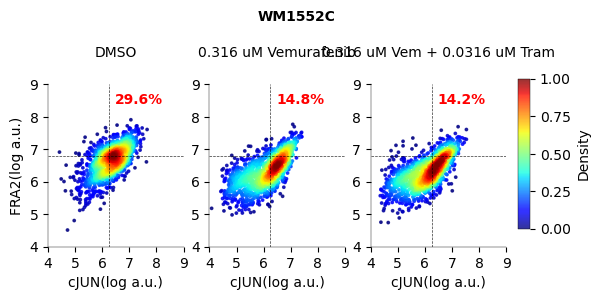

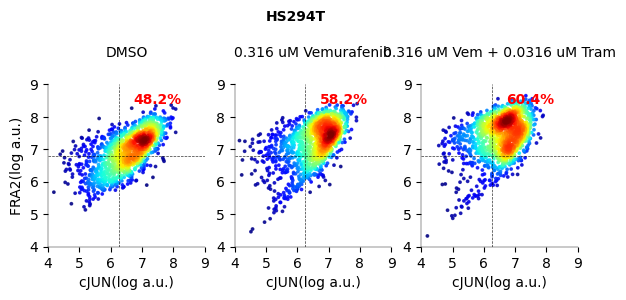

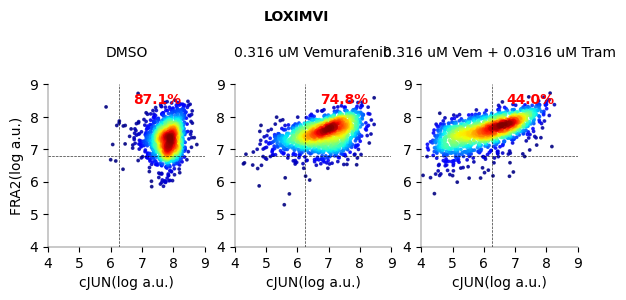

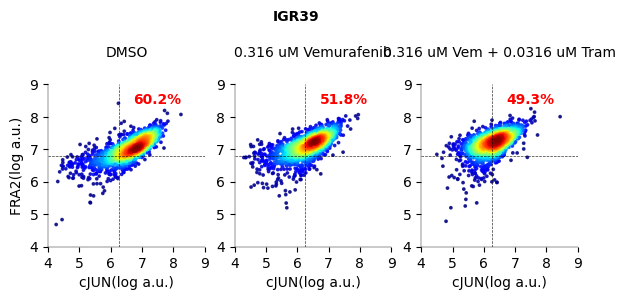

In [104]:
cells_A = ["COLO858","WM902B","RVH421","WM2664","A375"]
cells_B = ["WM1552C","HS294T","LOXIMVI","IGR39"]
cells_C = ["SKMEL5","SKMEL28","SKMEL19"]

figures = plot_pooled_flow_cytometry(
    sampled_df,
    celllines=cells_B,  
    conditions=['DMSO', '0.316 uM Vemurafenib', '0.316 uM Vem + 0.0316 uM Tram'],  
    x_column='cJUN', 
    y_column='FRA2',
    reference_cellline='WT',
    reference_condition='DMSO',
    figsize=(6, 3),
    save_pdf=True,
    save_dir='single cell densities drug treatments',
    dpi=300,
    fixed_gates=(6.25, 6.8)  # or let it calculate automatically
)

In [26]:
def plot_violin_drug_treatments(
    df: pd.DataFrame,
    protein: str,
    celllines=None,                  # order on x
    time=None,                       # optional filter
    show_ns: bool = True,
    ylim: tuple = (4, 9),
    figsize: tuple = None,           # auto if None
    rotate_xticks: int = 30,
    save_path: str = None,
    dpi: int = 300,
):
    # --- sanity
    needed = {"condition", "cellline", protein}
    miss = needed - set(df.columns)
    if miss:
        raise ValueError(f"Missing required columns: {miss}")

    def _tolist(x):
        if x is None:
            return None
        return x if isinstance(x, (list, tuple, pd.Series, np.ndarray, set)) else [x]

    celllines = _tolist(celllines)
    times = _tolist(time)

    cond_order = [
        "DMSO",
        "0.316 uM Vemurafenib",
        "0.316 uM Vem + 0.0316 uM Tram",
    ]
    palette = {
        "DMSO": "black",
        "0.316 uM Vemurafenib": "orange",
        "0.316 uM Vem + 0.0316 uM Tram": "red",
    }

    sub = df.copy()
    sub = sub[sub["condition"].isin(cond_order)]
    if celllines is not None:
        sub = sub[sub["cellline"].isin(celllines)]
    if times is not None and "time" in sub.columns:
        sub = sub[sub["time"].isin(times)]
    sub = sub.dropna(subset=["cellline", "condition", protein]).copy()

    # ordering
    cell_order = list(celllines) if celllines is not None else sorted(sub["cellline"].unique())
    sub["cellline"] = pd.Categorical(sub["cellline"], categories=cell_order, ordered=True)
    sub["condition"] = pd.Categorical(sub["condition"], categories=cond_order, ordered=True)

    # --- IMPROVED fig size - make it much wider and taller
    n_cells = len(cell_order)
    if figsize is None:
        fig_w = max(12, 3.5 * n_cells)  # Much wider: increased from 1.8 to 3.5
        fig_h = 8  # Increased height from 5.8 to 8 to accommodate p-values and legend
        figsize = (fig_w, fig_h)

    fig, ax = plt.subplots(figsize=figsize)

    # Match dodge math for annotation offsets
    m = 3                         # hue levels
    cat_width = 0.80              # must match seaborn 'width' below
    offsets = [-cat_width/2 + (k + 0.5) * cat_width / m for k in range(m)]
    offset_map = {
        "DMSO": offsets[0],
        "0.316 uM Vemurafenib": offsets[1],
        "0.316 uM Vem + 0.0316 uM Tram": offsets[2],
    }

    # --- main plot
    sns.violinplot(
        data=sub,
        x="cellline",
        y=protein,
        hue="condition",
        order=cell_order,
        hue_order=cond_order,
        palette=palette,
        cut=0,
        inner=None,
        #inner_kws=dict(box_width=8, whis_width=2, color="black"),
        linewidth=0.4,
        width=cat_width,        # keep in sync with offsets
        dodge=True,
        alpha=0.6,
        ax=ax,
    )
    box_width_abs = 0.12  # visual width of the boxes (independent of violin width)
    for i, cl in enumerate(cell_order):
        d_cl = sub[sub["cellline"] == cl]
        for cond, col in zip(cond_order, [palette[c] for c in cond_order]):
            yvals = d_cl.loc[d_cl["condition"] == cond, protein].dropna().to_numpy()
            if yvals.size == 0:
                continue
            xpos = i + offset_map[cond]
            bp = ax.boxplot(
                [yvals],
                positions=[xpos],
                widths=box_width_abs,
                vert=True,
                patch_artist=True,
                manage_ticks=False,
                showfliers=False,
                whis=1.5
            )
            # style
            for b in bp['boxes']:
                b.set(facecolor="none", edgecolor="black", linewidth=0.6, zorder=3)
            for w in bp['whiskers']:
                w.set(color="black", linewidth=0.6, zorder=3)
            for c in bp['caps']:
                c.set(color="black", linewidth=0.6, zorder=3)
            for m in bp['medians']:
                m.set(color="black", linewidth=0.8, zorder=4)
    ax.set_xlabel("")
    ax.set_ylabel(f"{protein} (log a.u.)")
    ax.set_ylim(ylim)
    ax.tick_params(axis="x", rotation=rotate_xticks)
    ax.tick_params(axis="y")
    #ax.set_title(f"{protein} under drug treatments", pad=20, fontsize=16, fontweight='bold')

    # IMPROVED horizontal legend at bottom - push it further down
    leg = ax.legend(
        title=None,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.25),  # Moved from -0.14 to -0.25 to push further down
        ncol=3,
        frameon=False,
        columnspacing=2.0,  # Increased spacing
        handlelength=2.0,   # Increased handle length
        borderaxespad=0.0,
        
    )
    def p_to_text(p: float) -> str:
        if p == 0 or p < 1e-300:  # Handle extremely small p-values
            return "p < 1e-300"
        elif p < 0.001:
            return f"p = {p:.1e}"
        elif p < 0.05:
            return f"p = {p:.3f}"
        else:
            return f"p = {p:.3f}" if show_ns else ""
    # IMPROVED p-value formatting with 10^x notation instead of e-notation
    # def p_to_text(p: float) -> str:
    #     if p == 0 or p < 1e-300:  # Handle extremely small p-values
    #         return "p < 1.0×10$^{-300}$"
    #     elif p < 0.001:
    #         # Convert to 10^x format
    #         try:
    #             exponent = int(np.floor(np.log10(p)))
    #             mantissa = p / (10 ** exponent)
    #             if mantissa >= 9.95:  # Round up case
    #                 mantissa = 1.0
    #                 exponent += 1
    #             return f"p = {mantissa:.1f}×10$^{{{exponent}}}$"
    #         except (OverflowError, ValueError):
    #             return "p < 1.0×10$^{-300}$"
    #     elif p < 0.05:
    #         return f"p = {p:.3f}"
    #     else:
    #         return f"p = {p:.3f}" if show_ns else ""


    def add_sig_bar(ax_, x0, x1, y, h, text, color="black", lw=0.3, fs=10):
        # Make the brackets slightly thicker and text larger
        ax_.plot([x0, x0, x1, x1], [y, y + h, y + h, y], c=color, lw=lw, clip_on=False)
        ax_.text((x0 + x1) / 2.0, y + h + 0.01, text, ha="center", va="bottom", 
                color=color, fontsize=fs)

    y_lo, y_hi = ylim
    y_span = y_hi - y_lo
    bar_h = 0.02 * y_span  # Slightly taller bars
    
    # IMPROVED p-value positioning - more space and better stacking
    for i, cl in enumerate(cell_order):
        d_cl = sub[sub["cellline"] == cl]
        dmso = d_cl.loc[d_cl["condition"] == cond_order[0], protein].to_numpy()
        vem  = d_cl.loc[d_cl["condition"] == cond_order[1], protein].to_numpy()
        combo= d_cl.loc[d_cl["condition"] == cond_order[2], protein].to_numpy()

        # Find local top for this cell line
        local_top = np.nanmax([dmso.max() if dmso.size else np.nan,
                               vem.max()  if vem.size  else np.nan,
                               combo.max()if combo.size else np.nan])
        if not np.isfinite(local_top):
            continue
            
        # IMPROVED positioning - more generous spacing
        base_y = min(y_hi - 0.25 * y_span, local_top + 0.08 * y_span)  
        step_y = 0.15 * y_span  # Increased from 0.10 to 0.15 for more separation

        # DMSO vs Vem comparison
        if dmso.size and vem.size:
            p1 = stats.wilcoxon(dmso, vem, alternative="greater").pvalue # changed from two-sided to greater
            t1 = p_to_text(p1)
            if t1:
                x0 = i + offset_map[cond_order[0]]
                x1 = i + offset_map[cond_order[1]]
                add_sig_bar(ax, x0, x1, base_y, bar_h, t1,color="red")

        # DMSO vs Combo comparison
        if dmso.size and combo.size:
            p2 = stats.wilcoxon(dmso, combo, alternative="greater").pvalue # changed from two-sided to greater
            t2 = p_to_text(p2)
            if t2:
                x0 = i + offset_map[cond_order[0]]
                x1 = i + offset_map[cond_order[2]]
                add_sig_bar(ax, x0, x1, base_y + step_y, bar_h, t2,color="red")

    # ADD SAMPLE COUNT LABELS at y=4.2
    sample_count_y = 4.2
    for i, cl in enumerate(cell_order):
        d_cl = sub[sub["cellline"] == cl]
        
        # Count samples for each condition in this cell line
        for j, condition in enumerate(cond_order):
            condition_data = d_cl[d_cl["condition"] == condition]
            n_samples = len(condition_data.dropna(subset=[protein]))
            
            if n_samples > 0:  # Only show count if there are samples
                x_pos = i + offset_map[condition]
                ax.text(x_pos, sample_count_y, f"n = {n_samples}", 
                       ha="center", va="center", fontsize=8, 
                       color='red')

    # IMPROVED layout with more padding
    plt.tight_layout(pad=3.0)  # Added padding
    plt.subplots_adjust(bottom=0.2)  # Make room for legend at bottom

    if save_path:
        os.makedirs(os.path.dirname(save_path) or ".", exist_ok=True)
        fig.savefig(save_path, bbox_inches="tight", dpi=dpi)

    return fig, ax

In [ ]:
cells_A = ["COLO858","WM902B","RVH421","WM2664","A375"]
cells_B = ["WM1552C","HS294T","LOXIMVI","IGR39"]
cells_C = ["SKMEL5","SKMEL28","SKMEL19"]
fig, ax = plot_violin_drug_treatments(
    sampled_df,
    protein="JUND",
    celllines=cells_A,
    time="24 h",
    figsize=(8, 4),
    save_path="Fig6D_violin_JUND_drug_treatments.pdf", #Fig6D_violin_JUND_drug_treatments.pdf
    rotate_xticks=30,
)

In [28]:
sampled_df.head()

,cFOS,cJUN,FRA1,FRA2,JUND,p-ERK,p-JNK,p-P38,p-FRA1,condition,time,cellline,rep_id
0,5.816240,7.156172,6.029017,7.125323,6.450595,3.520201,5.184653,5.155434,4.658264,0.316 uM Vem + 0.0316 uM Tram,24 h,A101D,1
1,5.883453,4.748708,5.949583,6.385437,6.378110,3.298753,5.003470,4.738971,4.446522,0.316 uM Vem + 0.0316 uM Tram,24 h,A101D,1
2,6.022373,6.825357,6.039747,6.922279,6.365687,3.498964,5.657810,4.666614,4.784490,0.316 uM Vem + 0.0316 uM Tram,24 h,A101D,1
3,5.845922,4.463802,6.326372,5.524371,6.818008,3.489666,4.981461,4.762739,4.298001,0.316 uM Vem + 0.0316 uM Tram,24 h,A101D,1
4,6.006190,5.348085,6.354984,6.635929,6.606633,3.393102,5.331368,4.754103,4.609627,0.316 uM Vem + 0.0316 uM Tram,24 h,A101D,1


In [30]:
# print the in each cell line and condition and rep_id
test = sampled_df.groupby(['cellline', 'condition', 'rep_id']).size().reset_index(name='count')
test

,cellline,condition,rep_id,count
0,A101D,0.316 uM Vem + 0.0316 uM Tram,1,300
1,A101D,0.316 uM Vem + 0.0316 uM Tram,2,300
2,A101D,0.316 uM Vemurafenib,1,300
3,A101D,0.316 uM Vemurafenib,2,300
4,A101D,DMSO,1,300
...,...,...,...,...
108,WM902B,0.316 uM Vem + 0.0316 uM Tram,2,300
109,WM902B,0.316 uM Vemurafenib,1,300
110,WM902B,0.316 uM Vemurafenib,2,300
111,WM902B,DMSO,1,300
